In [1]:
# import cf, cfplot as cfp
import numpy as np
import scipy as sp
import sys
import os
from netCDF4 import Dataset
import netCDF4 as nc
%matplotlib inline
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
import warnings

import matplotlib.pyplot as plt
import matplotlib.path as mpath
# Quick plot to show the results
from cartopy import config
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from cartopy.util import add_cyclic_point
import matplotlib.pylab as pl
from scipy import stats
import regionmask
import glob
import dask
from general_functions import *
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
def rebase(dataset,files):
    # ds = xr.open_dataset('intermediate_files/stable/gmst/tas_gmst_bq777.nc') #,engine='zarr')
    dates=dataset[0,].dropna(dim='year',how='all').year  
    datasets = []
    test=dataset
    for i in np.arange(0,int(dataset.shape[0])):
        tmp=test[i,:].dropna(dim='year',how='all')
        tmp['year']=dates
        datasets.append(tmp)
    dsnew = xr.concat(datasets, dim='cases')
    return(dsnew)
def preprocess(ds):
    print(ds.encoding['source'])
    return(ds)

def seasaverage_3(var,seas):
    season={'DJF':0,'JFM':1,'FMA':2,'MAM':3,'AMJ':4,'MJJ':5,'JJA':6,'JAS':7,'ASO':8,'SON':9,'OND':10,'NDJ':11,'ann':None}
    seasindex=season[seas]
    if (seas == 'ann'):
        var_seas=var.groupby('time.year').mean('time')
    else:
        if (var.ndim == 4):
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[:,seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time') #rename({"time":"year"})
        elif (var.ndim == 3): 
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time')
        # print(var_seas)
    return(var_seas)

In [3]:
factor={'tas':1,'pr':86400,'txx':1,'psl':1./100,'ua_850':1.,'evspsbl':86400,'va_850':1.,'uas':1.,'vas':1.,'msftyz':(1./(1000*1e6)),'siconca':1./100.,'rsut':1,'rlut':1,'rsdt':1}
zipgmststab=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc'))
zipgmst=xr.open_mfdataset(zipgmststab,combine='nested',concat_dim='cases')['tas']
zipgmst=np.nanmean(rebase(zipgmst,zipgmststab),axis=1)

def sortbygmst(input):
    input = [x for _,x in sorted(zip(zipgmst,input))]
    return(input)
def lonflip(var):
    var.coords['lon'] = xr.where(var.coords['lon'] > 180, var.coords['lon'] - 360, var.coords['lon'])
    var = var.sortby("lon", ascending=True)
    return(var)
def real_timeseries(nyear=1,seas='ann',var='tas',var2='tas',lat1=None,lat2=None,lon1=None,lon2=None):

    fileshist=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/historical/'+var+'/'+var+'_r*.nc'))
    hist=seasaverage_3(xr.open_mfdataset(fileshist,combine='nested',concat_dim='cases')[var2],seas)*factor[var] # gmst timeseries for all hist runs --> baseperiod

    lat=hist['lat']
    lon=hist['lon']

    base=hist[:,0:50,:,:].mean('cases').mean('year')
    files=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/'+var+'/'+var+'_?????.nc')))
    # print(files)
    ds=xr.open_mfdataset(files,combine='nested',concat_dim='cases')
    tas=seasaverage_3(ds[var2],seas)*factor[var]
    year=tas.year
    print(tas.lon)
    if (var == 'txx'):
        tas=tas.rename({'latitude':'lat','longitude':'lon'})
    if (var != 'pr'):
        tas_anom=tas-base
    else:
        tas_anom=100*(tas-base)/base
    landmask='/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/sftlf/gn/latest/sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
    ds1 = xr.open_dataset(landmask)
    landfrac=ds1['sftlf']/100.
    seafrac=1-landfrac

    mlat=ds['lat']
    weights = np.cos(np.deg2rad(mlat))
    weights.name = "weights"

    if (lat1 != None):
        tas_sub = lonflip(tas_anom).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
        weights_sub = weights.sel(lat=slice(lat1, lat2))
        tas_anom=tas_sub
        print(tas_anom.lon)
        weights=weights_sub
        landfrac=lonflip(landfrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
        seafrac=lonflip(seafrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

    GMST=tas_anom.weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    land=(mask_land(tas_anom)).weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    print(land)
    sea=(tas_anom).weighted(weights*seafrac).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    
    return(land,sea,GMST)

def transient_timeseries(nyear=1,seas='ann',var='tas',var2='tas',lat1=None,lat2=None,lon1=None,lon2=None):

    fileshist=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/historical/'+var+'/'+var+'_r*.nc'))
    hist=seasaverage_3(xr.open_mfdataset(fileshist,combine='nested',concat_dim='cases')[var2],seas)*factor[var] # gmst timeseries for all hist runs --> baseperiod

    lat=hist['lat']
    lon=hist['lon']
    base=hist[:,0:50,:,:].mean('cases').mean('year')
    files=sorted(glob.glob('EMs/'+var+'_Amon_UKESM1-0-LL_ssp370_ensmean_gn_*nc'))
    # print(files)
    ds=xr.open_mfdataset(files,combine='nested',concat_dim='time')
    tas=seasaverage_3(ds[var2],seas)*factor[var]
    year=tas.year
    print(tas.lon)
    if (var == 'txx'):
        tas=tas.rename({'latitude':'lat','longitude':'lon'})
    if (var != 'pr'):
        tas_anom=tas-base
    else:
        tas_anom=100*(tas-base)/base
    landmask='/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/sftlf/gn/latest/sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
    ds1 = xr.open_dataset(landmask)
    landfrac=ds1['sftlf']/100.
    seafrac=1-landfrac

    mlat=ds['lat']
    weights = np.cos(np.deg2rad(mlat))
    weights.name = "weights"

    if (lat1 != None):
        tas_sub = lonflip(tas_anom).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
        weights_sub = weights.sel(lat=slice(lat1, lat2))
        tas_anom=tas_sub
        print(tas_anom.lon)
        weights=weights_sub
        landfrac=lonflip(landfrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
        seafrac=lonflip(seafrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

    GMST=tas_anom.weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    land=(mask_land(tas_anom)).weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    print(land)
    sea=(tas_anom).weighted(weights*seafrac).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    
    return(land,sea,GMST)

<xarray.DataArray 'lon' (lon: 192)>
array([  0.9375,   2.8125,   4.6875,   6.5625,   8.4375,  10.3125,  12.1875,
        14.0625,  15.9375,  17.8125,  19.6875,  21.5625,  23.4375,  25.3125,
        27.1875,  29.0625,  30.9375,  32.8125,  34.6875,  36.5625,  38.4375,
        40.3125,  42.1875,  44.0625,  45.9375,  47.8125,  49.6875,  51.5625,
        53.4375,  55.3125,  57.1875,  59.0625,  60.9375,  62.8125,  64.6875,
        66.5625,  68.4375,  70.3125,  72.1875,  74.0625,  75.9375,  77.8125,
        79.6875,  81.5625,  83.4375,  85.3125,  87.1875,  89.0625,  90.9375,
        92.8125,  94.6875,  96.5625,  98.4375, 100.3125, 102.1875, 104.0625,
       105.9375, 107.8125, 109.6875, 111.5625, 113.4375, 115.3125, 117.1875,
       119.0625, 120.9375, 122.8125, 124.6875, 126.5625, 128.4375, 130.3125,
       132.1875, 134.0625, 135.9375, 137.8125, 139.6875, 141.5625, 143.4375,
       145.3125, 147.1875, 149.0625, 150.9375, 152.8125, 154.6875, 156.5625,
       158.4375, 160.3125, 162.1875, 164

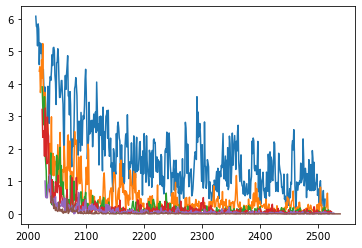

In [4]:
tas_land, tas_sea, GMST = real_timeseries() #lat1=10,lat2=60,lon1=-100,lon2=50)
pr_land, pr_sea, pr_global = real_timeseries(var='pr',var2='pr')
pr_land_t, pr_sea_t, pr_global_t = transient_timeseries(var='pr',var2='pr')
tas_land_t, tas_sea_t, GMST_t = transient_timeseries(var='tas',var2='tas')
rsut_land, rsut_sea, rsut_global = real_timeseries(var='rsut',var2='rsut')
rlut_land, rlut_sea, rlut_global = real_timeseries(var='rlut',var2='rlut')
rsdt_land, rsdt_sea, rsdt_global = real_timeseries(var='rsdt',var2='rsdt')

rsut_land_t, rsut_sea_t, rsut_global_t = transient_timeseries(var='rsut',var2='rsut')
rlut_land_t, rlut_sea_t, rlut_global_t = transient_timeseries(var='rlut',var2='rlut')
rsdt_land_t, rsdt_sea_t, rsdt_global_t = transient_timeseries(var='rsdt',var2='rsdt')


var='siconca'
files=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/'+var+'/'+var+'_?????.nc')))
ds=xr.open_mfdataset(files,combine='nested',concat_dim='cases')
# siconca=ds['siconca'][:,8::12,:,:]*factor[var]
# print(ds['siconca'].shape)
siconca=ds['siconca'].sel(time=ds['siconca'].time['time.month']==9)*factor[var]
print(siconca.shape)

cell_area = '/gws/nopw/j04/smurphs/E/adittus/output/areacella.nc'
dsic = xr.open_dataset(cell_area)
cell_area=dsic['cell_area'].values
SIA=((siconca*cell_area).sel(lat=slice(70,92)).sum(axis=(2,3),skipna=True))/1e12
SIA=SIA.where(SIA != 0)  
for i in np.arange(0,6):
    plt.plot(SIA[i,:]['time.year'],SIA[i,:])

files=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/ssp370/'+var+'/'+var+'_r*i1p1f2.nc'))
ds=xr.open_mfdataset(files,combine='nested',concat_dim='cases')
siconca_t=ds['siconca'].sel(time=ds['siconca'].time['time.month']==9)*factor[var]
SIA_t=(siconca_t*cell_area).sel(lat=slice(70,92)).sum(axis=(2,3))/1e12
# print(SIA_t[:,0:10])

# year=tas.year
    # print(tas.lon)
    # if (var == 'txx'):
    #     tas=tas.rename({'latitude':'lat','longitude':'lon'})
    # print("rebasing...")
    # if (var != 'pr'):
    #     tas_anom=tas-base
    # else:
    #     tas_anom=100*(tas-base)/base
    # landmask='/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/sftlf/gn/latest/sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
    # ds1 = xr.open_dataset(landmask)
    # landfrac=ds1['sftlf']/100.
    # seafrac=1-landfrac

    # mlat=ds['lat']
    # weights = np.cos(np.deg2rad(mlat))
    # weights.name = "weights"

    # if (lat1 != None):
    #     tas_sub = lonflip(tas_anom).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    #     weights_sub = weights.sel(lat=slice(lat1, lat2))
    #     tas_anom=tas_sub
    #     print(tas_anom.lon)
    #     weights=weights_sub
    #     landfrac=lonflip(landfrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    #     seafrac=lonflip(seafrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

    # GMST=tas_anom.weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    # land=(mask_land(tas_anom)).weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    # print(land)
    # sea=(tas_anom).weighted(weights*seafrac).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()

(6, 526)
<class 'xarray.core.dataarray.DataArray'>


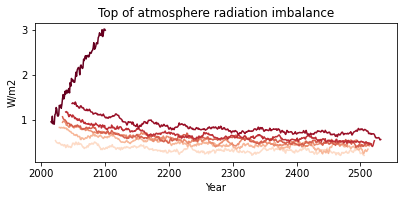

In [5]:
fig, axlist = plt.subplots(nrows=1, ncols=1, figsize=(11/2, 8/3), constrained_layout=True,squeeze=False)
ax=axlist.flatten()
cmap = plt.cm.get_cmap('RdBu_r')
col=np.linspace(0.6,1,7)
imbalance=rsdt_global-(rlut_global+rsut_global)
imbalance_t=rsdt_global_t-(rlut_global_t+rsut_global_t)
print(imbalance.shape)
print(type(imbalance))
for i in np.arange(0,6):
    ax[0].plot(imbalance[i,:].year,imbalance[i,].rolling(min_periods=16, center=True, year=16).mean().values,c=cmap(col[i]))
ax[0].plot(imbalance_t.year,imbalance_t.values,c=cmap(col[6]))
ax[0].set_title('Top of atmosphere radiation imbalance')
ax[0].set_ylabel("W/m2")
ax[0].set_xlabel("Year")
plt.savefig('TOA_imbalance.eps')

In [6]:
cmap = plt.cm.get_cmap('RdBu_r')
col=np.linspace(0.6,1,7)
var='msftyz'
i=0
# amoc=np.full((500,6),np.nan)
# amoc_year=np.full((500,6),np.nan)
for run in ['bq777','bw848','bz227','cd269','bw987','bu607']:
    files=glob.glob('/gws/nopw/j04/realproj/users/adittus/cdds/u-'+run+'/cdds_data/CMIP6/CMIP/UKESM1-0-LL/piControl/r*i1p1f2/round-8/output/onm/Omon/msftyz/*nc')
    ds=xr.open_mfdataset(files,combine='nested',concat_dim='time') #,preprocess=preprocess)
    var_ann=seasaverage_3(ds['msftyz'],'ann').sel(rlat=40.,method='nearest',tolerance=0.5)
    if (run == 'bq777'):
        amoc=(var_ann[:,0,:].max(dim='lev'))*factor['msftyz']
    else:
        amoc=xr.concat([amoc,(var_ann[:,0,:].max(dim='lev')*factor['msftyz'])],dim='cases')
print(amoc.shape)

/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc i

(6, 526)


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


1
hello
1


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


2
hello
2


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


3
hello
3


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


4
hello
4


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


5
hello
5


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


6
hello
6


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


7
hello
7


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


8
hello
8


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


9
hello
9


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


10
hello
10


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


11
hello
11


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


12
hello
12


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


13
14
15
16
hello
16


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


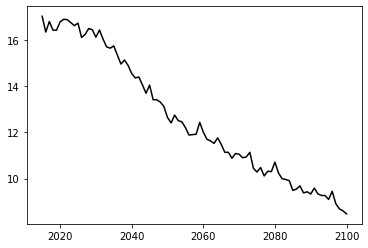

In [7]:
scenario='ssp370'
for r in np.arange(1,17):
    print(r)
    files=glob.glob('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/'+scenario+'/r'+str(r)+'i1p1f2/Omon/msftyz/gn/latest/*nc')
    # print(files)
    if (files):
        ds2=xr.open_mfdataset(files,combine='nested',concat_dim='time')
        var_ann2=seasaverage_3(ds2['msftyz'],'ann').sel(rlat=40.,method='nearest',tolerance=0.5)
        # amoc_t[:,i]=(var_ann2[:,0,:].max(dim='lev').rolling(min_periods=20, center=True, year=20).mean())*factor['msftyz']
        if (r == 1):
            amoc_t=(var_ann2[:,0,:].max(dim='lev'))*factor['msftyz']
        else:
            amoc_t=xr.concat([amoc_t,(var_ann2[:,0,:].max(dim='lev'))*factor['msftyz']],dim='cases')
        #amoc_year2[:,i]=var_ann2['year'].values

plt.plot(amoc_t.year,np.nanmean(amoc_t.values,axis=0),c='black')


<Figure size 432x288 with 0 Axes>

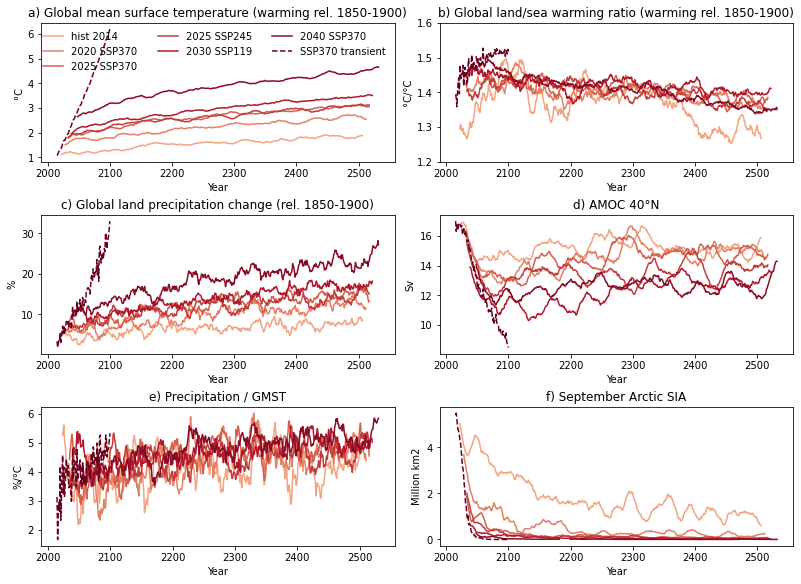

In [8]:
base_period_string='1850-1900'
reg='Global'
linelist=[]
# runid=['hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370','SSP370 parent transient run']
# fig, axlist = plt.subplots(nrows=3, ncols=2, figsize=(11, 5), constrained_layout=True) # figsize width then height
cmap = plt.cm.get_cmap('RdBu_r')
col=np.linspace(0.7,1,7) #np.linspace(0.6,1,7)
# ax=axlist.flatten()
# for i in np.arange(0,6):
#     test=ax[i].plot(tas_land[i,]/tas_sea[i,],c=cmap(col[i]))
#     ax[i].set_ylim(0.5,2.2)
#     ax[i].set_title(reg+' land/sea warming ratio rel. 1984-2014')
#     ax[i].legend(test, [runid[i]],frameon=False,fontsize=10)
plt.savefig(reg+'_land-sea warming ratio_rel1984.eps')
fig, axlist = plt.subplots(nrows=3, ncols=2, figsize=(11, 8), constrained_layout=True)
ax=axlist.flatten()
for i in np.arange(0,6):
    lines,=ax[0].plot(GMST[i,].year,GMST[i,].rolling(min_periods=16, center=True, year=16).mean().values,c=cmap(col[i]))
    linelist.append(lines)  
    ax[0].set_title('a) Global mean surface temperature (warming rel. '+base_period_string+')')
    ax[0].set_ylabel("°C")
    ax[0].set_xlabel("Year")
    ax[1].plot(tas_land[i,].year,(tas_land[i,]/tas_sea[i,]).rolling(min_periods=16, center=True, year=16).mean().values,c=cmap(col[i]))
    ax[1].set_title('b) '+reg+' land/sea warming ratio (warming rel. '+base_period_string+')')
    ax[1].set_ylim(1.2,1.6)
    ax[1].set_ylabel("°C/°C")
    ax[1].set_xlabel("Year")
    ax[2].plot(pr_land[i,].year,pr_land[i,].rolling(min_periods=16, center=True, year=16).mean().values,c=cmap(col[i]))
    ax[2].set_title('c) '+reg+' land precipitation change (rel. '+base_period_string+')')
    ax[2].set_ylabel("%")
    ax[2].set_xlabel("Year")
    # ax[3].plot(pr_sea[i,],c=cmap(col[i]))
    # ax[3].set_title(reg+' ocean precipitation change (rel. '+base_period_string+')')
    # ax[3].set_ylabel("%")
    ax[3].plot(amoc[i,:].year,amoc[i,:].rolling(min_periods=16, center=True, year=16).mean().values,c=cmap(col[i]))
    ax[3].set_title('d) AMOC 40°N')
    ax[3].set_ylabel("Sv")
    ax[3].set_xlabel("Year")
    ax[4].plot(pr_land[i,].year,pr_land[i,].rolling(min_periods=16, center=True, year=16).mean().values/GMST[i,].rolling(min_periods=20, center=True, year=20).mean().values,c=cmap(col[i]))
    ax[4].set_title('e) Precipitation / GMST')
    ax[4].set_ylabel("%/°C")
    ax[4].set_xlabel("Year")
    ax[5].plot(SIA[i,:]['time.year'],SIA[i,:].rolling(min_periods=16, center=True, time=16).mean().values,c=cmap(col[i]))
    ax[5].set_title('f) September Arctic SIA')
    ax[5].set_ylabel("Million km2")
    ax[5].set_xlabel("Year")
lines,=ax[0].plot(GMST_t.year,GMST_t.rolling(min_periods=1, center=True, year=1).mean().values,c=cmap(col[6]),linestyle='dashed')
linelist.append(lines)  
ax[1].plot(pr_land_t.year,(tas_land_t/tas_sea_t).values,c=cmap(col[6]),linestyle='dashed')
ax[2].plot(pr_land_t.year,pr_land_t.values,c=cmap(col[6]),linestyle='dashed')
ax[3].plot(amoc_t.year,amoc_t.mean('cases').values,c=cmap(col[6]),linestyle='dashed')
ax[4].plot(pr_land_t.year,pr_land_t.values/GMST_t.values,c=cmap(col[6]),linestyle='dashed')
# ax[5].plot(pr_land_t.year,pr_land_t.rolling(min_periods=1, center=True, year=1).mean().values/GMST_t.rolling(min_periods=1, center=True, year=1).mean().values,c=cmap(col[6]),linestyle='dashed')
ax[5].plot(SIA_t.mean('cases')['time.year'],SIA_t.mean('cases').values,c=cmap(col[6]),linestyle='dashed')


ax[0].legend([linelist[0],linelist[1],linelist[2],linelist[3],linelist[4],linelist[5],linelist[6]], ['hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370','SSP370 transient'],frameon=False,fontsize=10, ncol=3)
plt.savefig(reg+'_land-sea_gmst_1fig_'+base_period_string+'.png',dpi=300)
    # ax[1].legend([test[0],test[1],test[2],test[3],test[4],test[5],test[6]], ['hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370','SSP370 parent transient run'],frameon=False,fontsize=10)